In [19]:
import pandas as pd
import numpy as np
import os

# pip install python-dotenv

file_path = os.getenv("FILE_PATH")
file_path

'C:/Users/joshu/OneDrive/Desktop/Practitioner Challenge/challenge'

In [20]:
SNP_prices_file = f'{file_path}/S&P 500 Index.csv'
SNP_VIX_file = f'{file_path}/S&P 500 VIX.csv'

### S&P500 Prices

In [21]:
# Load the CSV file into df
SNP = pd.read_csv(SNP_prices_file)
SNP.columns = ["date", "price"]
SNP["date"] = pd.to_datetime(SNP["date"])
SNP = SNP.sort_values(by="date")

# Calculating log prices
SNP["log_returns"] = np.log(SNP["price"]/ SNP["price"].shift(1))
SNP = SNP[1:]
SNP.head()

,date,price,log_returns
2514,2015-01-05,2020.58,-0.018447
2513,2015-01-06,2002.61,-0.008933
2512,2015-01-07,2025.90,0.011563
2511,2015-01-08,2062.14,0.017730
2510,2015-01-09,2044.81,-0.008439


In [22]:
import plotly.express as px
import plotly.graph_objects as go

# Assuming SNP is your DataFrame with 'date' and 'log_returns' columns
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=SNP["date"], 
    y=SNP["log_returns"], 
    mode='lines+markers', 
    name="S&P 500 Index"
))

fig.update_layout(
    title="S&P 500 Index Time Series",
    xaxis_title="Date",
    yaxis_title="Index Value",
    xaxis=dict(rangeslider=dict(visible=True)),  # Adds a range slider for better navigation
    template="plotly_white"  # Clean background
)

fig.show()

In [23]:
# Define start and end dates
SNP_training_start, SNP_training_end = "2015-01-01", "2022-12-31"
SNP_testing_start, SNP_testing_end = "2023-01-01", "2024-12-31"

# Filter the DataFrame
SNP_training_df = SNP[(SNP['date'] >= SNP_training_start) & (SNP['date'] <= SNP_training_end)]
SNP_testing_df = SNP[(SNP['date'] >= SNP_testing_start) & (SNP['date'] <= SNP_testing_end)]

In [24]:
import pywt
import matplotlib.pyplot as plt
from scipy.stats import linregress

def hurst_wavelet(series, wavelet='haar', max_level=6):
    """
    Estimates the Hurst exponent using wavelet analysis.
    
    Parameters:
        series (pd.Series): Time series data (log returns or prices)
        wavelet (str): Type of wavelet (e.g., 'haar', 'db2')
        max_level (int): Maximum decomposition level

    Returns:
        float: Estimated Hurst exponent
    """

    # Ensure it's a NumPy array
    data = np.array(series)
    
    # Perform multi-level Discrete Wavelet Transform (DWT)
    coeffs = pywt.wavedec(data, wavelet, level=max_level)

    # Compute variances of detail coefficients at each level
    scales = np.array([2**i for i in range(1, len(coeffs))])  # Scale levels
    variances = np.array([np.var(c) for c in coeffs[1:]])  # Ignore approximation coefficients

    # Log-log regression to estimate H
    log_scales = np.log2(scales)
    log_variances = np.log2(variances)

    # Perform linear regression
    slope, intercept, _, _, _ = linregress(log_scales, log_variances)
    
    # Hurst exponent estimate (slope is related to H as H = (slope + 1)/2)
    hurst_exponent = (slope + 1) / 2

    # Plot Log-Log Variance vs. Scale
    plt.figure(figsize=(8, 5))
    plt.scatter(log_scales, log_variances, label="Wavelet Coeff Variances")
    plt.plot(log_scales, intercept + slope * log_scales, color='red', linestyle="--", label="Linear Fit")
    plt.xlabel("log2(Scale)")
    plt.ylabel("log2(Variance)")
    plt.title(f"Hurst Exponent Estimation (H = {hurst_exponent:.4f})")
    plt.legend()
    plt.grid()
    plt.show()

    return hurst_exponent

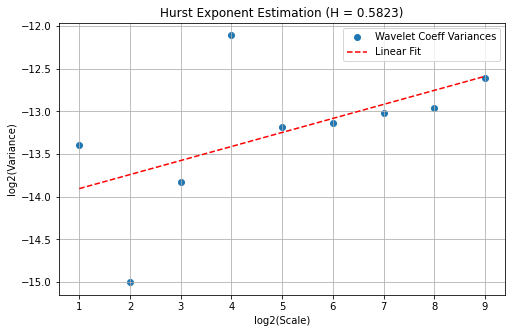

Estimated Hurst Exponent: 0.5823


In [25]:
# Example usage on S&P 500 log returns
SNP_hurst_est = hurst_wavelet(SNP_training_df["log_returns"], wavelet='haar', max_level=9)
print(f"Estimated Hurst Exponent: {SNP_hurst_est:.4f}")

In [26]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss

def stationarity_tests(series):
    """
    Performs ADF and KPSS tests on a time series.

    Parameters:
        series (pd.Series): The time series data.

    Returns:
        None (Prints test results)
    """
    # Augmented Dickey-Fuller Test (ADF)
    adf_result = adfuller(series, autolag='AIC')
    print("Augmented Dickey-Fuller Test Results:")
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]:.4f}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"   {key}: {value:.4f}")
    print("➡ Stationary" if adf_result[1] < 0.05 else "➡ Non-Stationary")

    print("\n" + "="*50 + "\n")

    # KPSS Test
    kpss_result = kpss(series, regression='c', nlags="auto")  # 'c' = constant (level stationarity)
    print("KPSS Test Results:")
    print(f"KPSS Statistic: {kpss_result[0]:.4f}")
    print(f"p-value: {kpss_result[1]:.4f}")
    print("Critical Values:")
    for key, value in kpss_result[3].items():
        print(f"   {key}: {value:.4f}")
    print("➡ Non-Stationary" if kpss_result[1] < 0.05 else "➡ Stationary")

# Run the tests on S&P 500 log returns
stationarity_tests(SNP["log_returns"])

Augmented Dickey-Fuller Test Results:
ADF Statistic: -15.7254
p-value: 0.0000
Critical Values:
   1%: -3.4330
   5%: -2.8627
   10%: -2.5674
➡ Stationary


KPSS Test Results:
KPSS Statistic: 0.0495
p-value: 0.1000
Critical Values:
   10%: 0.3470
   5%: 0.4630
   2.5%: 0.5740
   1%: 0.7390
➡ Stationary


c:\Users\joshu\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




### S&P500 VIX Analysis

In [27]:
# Load the CSV file into df
VIX = pd.read_csv(SNP_VIX_file)
VIX.columns = ["vol"]
VIX.index = pd.to_datetime(VIX.index)
VIX.sort_index()
VIX["log_vol_diff"] = np.log(VIX['vol']/ VIX['vol'].shift(1))
VIX = VIX[1:]

VIX.head()

,vol,log_vol_diff
2024-12-30,17.40,0.002878
2024-12-27,15.95,-0.087011
2024-12-26,14.73,-0.079573
2024-12-24,14.27,-0.031727
2024-12-23,16.78,0.162028


In [28]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# supress soon to be deprecated feature error (slicing indices with missing dates) 

vix_training_start, vix_training_end = "2015-01-01", "2022-12-31"
vix_testing_start, vix_testing_end = "2023-01-01", "2024-12-31"

vix_training_df = VIX.loc[vix_training_start:vix_training_end]
vix_testing_df = VIX.loc[vix_testing_start:vix_testing_end]
vix_training_df.head()

,vol,log_vol_diff
2022-12-30,21.67,-0.055208
2022-12-29,21.44,-0.010670
2022-12-28,22.14,0.032128
2022-12-27,21.65,-0.022380
2022-12-23,20.87,-0.036693


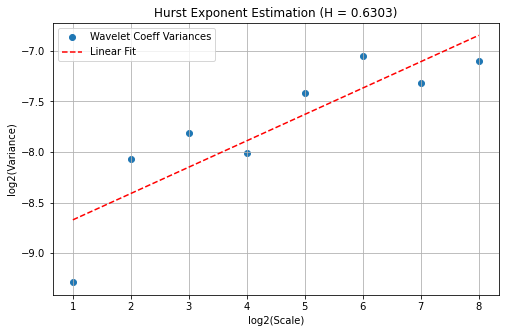

0.6302821171043524

In [30]:
vix_hurst_est = hurst_wavelet(vix_training_df["log_vol_diff"], wavelet='haar', max_level=8)
vix_hurst_est

In [55]:
from stochastic.processes.continuous import FractionalBrownianMotion
import numpy as np
import random
import plotly.graph_objects as go

def generate_fbm(train_data, test_data, H):
    # Set a fixed seed inside the function for reproducibility
    random.seed(42)
    np.random.seed(42)

    # Calculate drift (μ) and volatility (σ) from training log returns
    mu = train_data["log_returns"].mean()  # Drift set to 0 for now
    sigma = train_data["log_returns"].std()

    # Define Fractional Brownian Motion (fBM) model
    n_days = len(test_data)  # Number of forecast days

    # ✅ Set seed before generating fBM to ensure reproducibility
    fbm = FractionalBrownianMotion(hurst=H, t=n_days-1)
    fbm_values = fbm.sample(n=n_days-1)  # Generate fBM values

    # Convert fBM to a stock price forecast
    S0 = train_data["log_returns"].iloc[-1]  # Last known price

    # Simulate price paths using geometric fractional Brownian motion
    simulated_prices = S0 * np.exp(mu * np.arange(n_days) + sigma * fbm_values)

    # Create a Plotly figure for actual vs. simulated prices
    fig = go.Figure()

    # Actual price trace
    fig.add_trace(go.Scatter(
        x=test_data.index,
        y=test_data["log_returns"],
        mode='lines',
        name='Actual Price',
        line=dict(color='blue')
    ))

    # Forecasted price trace using fBM
    fig.add_trace(go.Scatter(
        x=test_data.index,
        y=simulated_prices,
        mode='lines',
        name='Forecasted Price (fBM)',
        line=dict(color='red', dash='dash')
    ))

    # Update layout of the plot
    fig.update_layout(
        title=f"Stock Price Forecast using fBM (H={H})",
        xaxis_title="Date",
        yaxis_title="Stock Price",
        template="plotly_white"
    )

    # Display the interactive plot
    fig.show()


In [62]:
generate_fbm(SNP_training_df, SNP_testing_df, vix_hurst_est)

In [37]:
pip install yfinance

  Using cached requests-2.32.3-py3-none-any.whl (64 kB)
  Using cached html5lib-1.1-py2.py3-none-any.whl (112 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)
  Created wheel for peewee: filename=peewee-3.17.9-py3-none-any.whl size=139096 sha256=e2b2db891257ea4f7f51ede1bc2460afd3381a09ea32796bf3854c80b28f7e7b
  Stored in directory: c:\users\joshu\appdata\local\pip\cache\wheels\95\bb\20\859b0853d3683815ccb6342d9ac5a49380a681c96285821184
Successfully built peewee
  Attempting uninstall: pytz
    Found existing installation: pytz 2021.3
    Uninstalling pytz-2021.3:
      Successfully uninstalled pytz-2021.3
  Attempting uninstall: requests
    Found existing install

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.


-0.0001249383517478716
0.0820823156815136


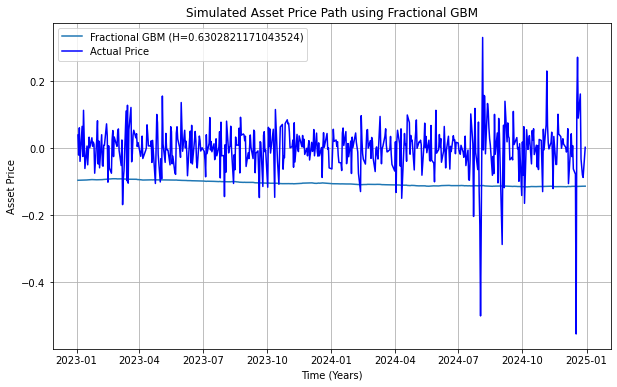

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from fbm import FBM

def simulate_fractional_gbm(S0, mu, sigma, T, dt, H):
    """
    Simulate an asset price using fractional Brownian motion.
    
    The asset price follows:
      S(t) = S0 * exp{ mu * t - (1/2)*sigma^2*t^(2H) + sigma * B^H(t) }
    
    Parameters:
        S0 (float): Initial asset price.
        mu (float): Drift (annual expected return).
        sigma (float): Volatility.
        T (float): Total time horizon (in years).
        dt (float): Time step (in years).
        H (float): Hurst exponent of the fractional Brownian motion.
        
    Returns:
        t (ndarray): Array of time points.
        S (ndarray): Simulated asset prices.
    """
    N = int(T/dt) + 1  # number of time points, including t=0
    t = np.linspace(0, T, N)
    
    # Generate a fractional Brownian motion path using the Davies-Harte method.
    # The FBM class from the fbm package generates a path of fBM with n increments.
    fbm_process = FBM(n=N-2, hurst=H, length=T, method='daviesharte')
    B_H = np.concatenate(([0], fbm_process.fbm()))
    
    # Compute the asset price path using the fractional GBM formula.
    S = S0 * np.exp(mu * t - 0.5 * sigma**2 * t**(2 * H) + sigma * B_H)
    return t, S

# Example usage:
S0 = vix_training_df["log_vol_diff"][-1]
mu = vix_training_df["log_vol_diff"].mean()        # Drift (7% annual return)
sigma = vix_training_df["log_vol_diff"].std()      # Volatility (15% annual volatility)
T = 3.0           # Time horizon of 1 year
dt = 1/252        # Daily time steps (approximately 252 trading days per year)
H = vix_hurst_est          # Example Hurst exponent (indicating persistent behavior)

print(mu)
print(sigma)
# Run the simulation
t, S = simulate_fractional_gbm(S0, mu, sigma, T, dt, H)

vix_testing_df['actual'] = S[:515]
vix_testing_df['actual'] = vix_testing_df['actual']
vix_testing_df.head()

# Plot the simulated asset price path
plt.figure(figsize=(10, 6))
plt.plot(vix_testing_df.index, vix_testing_df["actual"], label=f"Fractional GBM (H={H})")
plt.plot(vix_testing_df.index, vix_testing_df["log_vol_diff"], label="Actual Price", color='blue')
plt.title("Simulated Asset Price Path using Fractional GBM")
plt.xlabel("Time (Years)")
plt.ylabel("Asset Price")
plt.legend()
plt.grid(True)
plt.show()

,vol,log_vol_diff,actual
2024-12-30,17.40,0.002878,-0.113088
2024-12-27,15.95,-0.087011,-0.113087
2024-12-26,14.73,-0.079573,-0.113172
2024-12-24,14.27,-0.031727,-0.113177
2024-12-23,16.78,0.162028,-0.113254


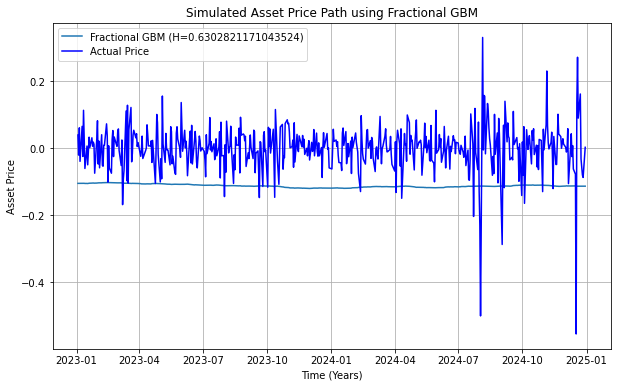